<a href="https://colab.research.google.com/github/shankch/reverse-image/blob/main/5_reduce_feature_length_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the speed of feature extraction and similarity search

We will experiment with PCA and figure out what is the optimum length of the features to use in our experiments.

## Reduce feature length with PCA

PCA (short for Principal Component Analysis) is a statistical procedure that questions if features representing the data are equally important. Are some of the features redundant enough that we can get similar results on say classification even after removing those features? PCA is considered one of the go-to techniques for dimensionality reduction. Note that it does not eliminate redundant features, instead it generates a new set of features that are a linear combination of the input features. These linear features are orthogonal to each other, which is why all the redundant features are absent. These features are known as principal components. 


We are going to perform PCA using the scikit-learn library.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir data
!cp -a drive/MyDrive/c99t1/* data/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists


In [14]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib inline

In [7]:
filenames = pickle.load(open('data/filenames-udset.pickle', 'rb'))
feature_list = pickle.load(open('data/features-udset-resnet.pickle',
                                'rb'))
class_ids = pickle.load(open('data/class_ids-udset.pickle', 'rb'))

In [8]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  2100
Number of features per image =  2048


In [9]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(100.0 * correct_prediction /(1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [10]:
print("Accuracy on original feature set : ", calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (87.31, 31.886093616485596)


In [12]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  16.96 % ,	Time =  1.2159557342529297
For PCA Dimensions =  2 ,	Accuracy =  34.29 % ,	Time =  1.273543119430542
For PCA Dimensions =  3 ,	Accuracy =  45.92 % ,	Time =  1.2736525535583496
For PCA Dimensions =  4 ,	Accuracy =  51.42 % ,	Time =  1.3042941093444824
For PCA Dimensions =  5 ,	Accuracy =  58.51 % ,	Time =  1.324117660522461
For PCA Dimensions =  10 ,	Accuracy =  74.64 % ,	Time =  1.9723615646362305
For PCA Dimensions =  20 ,	Accuracy =  83.54 % ,	Time =  2.125105619430542
For PCA Dimensions =  50 ,	Accuracy =  87.7 % ,	Time =  2.9400863647460938
For PCA Dimensions =  75 ,	Accuracy =  87.67 % ,	Time =  3.350024700164795
For PCA Dimensions =  100 ,	Accuracy =  87.75 % ,	Time =  3.6466238498687744
For PCA Dimensions =  150 ,	Accuracy =  88.01 % ,	Time =  4.520791530609131
For PCA Dimensions =  200 ,	Accuracy =  88.08 % ,	Time =  5.337686538696289


Let's plot the test time accuracy for each PCA dimension.

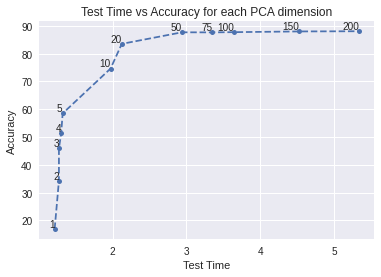

In [15]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

In [16]:
f.savefig('pca-test_time_vs_acc.pdf', bbox_inches='tight')
f.savefig('pca-test_time_vs_acc.png', transparent=False, bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence, 100 would be an ideal feature length for this dataset. This also means that the first 100 dimensions contain the most information about the dataset.


Let's plot the variance of each PCA dimension.

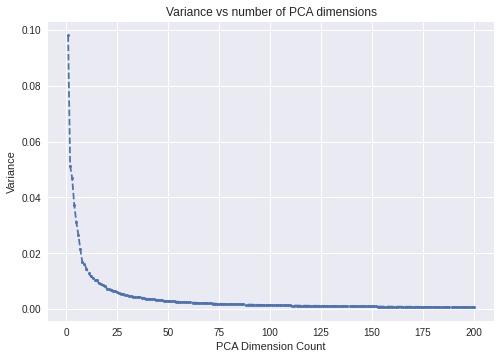

In [17]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

f.savefig("Variance vs number of PCA dimensions.pdf", bbox_inches='tight')
f.savefig("Variance vs number of PCA dimensions.png", bbox_inches='tight')

The individual variance will tell us how important the newly added features are. For example, after the first 100 dimensions, the additional dimensions don’t add much variance (almost equal to 0) and can be neglected. Without even checking the accuracy it is safe to assume that the PCA with 100 dimensions will be a  robust model. Another way to look at this is to visualize how much of the original data is explained by the limited number of features by finding the cumulative variance.

### Cumulative Variance vs number of PCA dimensions.

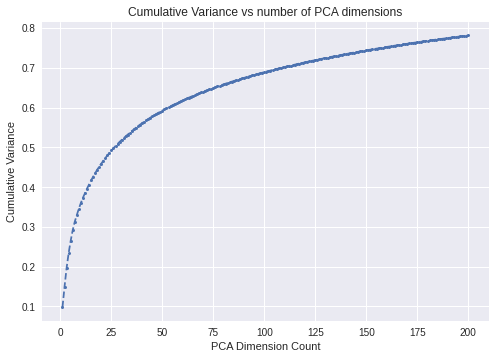

In [18]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

f.savefig("Cumulative Variance vs number of PCA dimensions.pdf",
          bbox_inches='tight')
f.savefig("Cumulative Variance vs number of PCA dimensions.png",
          bbox_inches='tight')

As expected adding 100 dimensions (from 100 to 200) adds only .1 variance and starts to gradually plateau. For reference, using full 2048 features would result in a cumulative variance of 1. 


### Plotting the effect of PCA dimension vs Classification Accuracy.

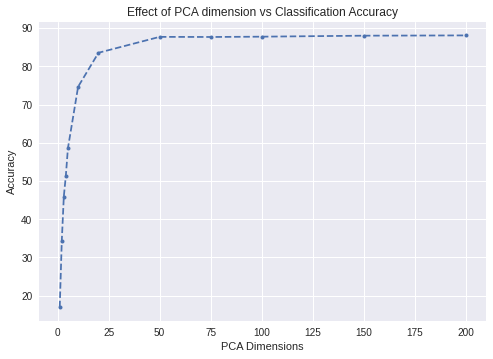

In [19]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_accuracy, 'o--', markersize=4)
plt.title('Effect of PCA dimension vs Classification Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimension vs Classification Accuracy.pdf",
          bbox_inches='tight')
f.savefig("Effect of PCA dimension vs Classification Accuracy.png",
          bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. With almost 20 times lesser dimensions (100) that the original (2048), this offers drastically higher speed and less time on almost any search algorithm, while getting similar (and sometimes slightly better) accuracy. Hence 100 would be an ideal feature length for this dataset.

We will now plot the effect of number of PCA dimensions vs time.

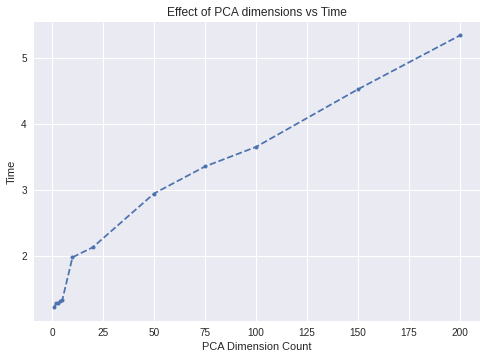

In [20]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_time, 'o--', markersize=4)
plt.title('Effect of PCA dimensions vs Time')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Time')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimensions vs Time.pdf", bbox_inches='tight')
f.savefig("Effect of PCA dimensions vs Time.png", bbox_inches='tight')

Now let's compare different options available for similarity search

In [39]:
num_items = 2100
num_dimensions = 100

In [40]:
dataset = np.random.randn(num_items, num_dimensions)
dataset /= np.linalg.norm(dataset, axis=1).reshape(-1, 1)

In [42]:
randomIndex = random.randint(0, num_items)
query = dataset[randomIndex]

### Brute force

In [43]:
# Time the indexing for the brute force algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(dataset)

The slowest run took 13.64 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 154 µs per loop


In [44]:
# Time the search for the brute force algorithm
neighbors = NearestNeighbors(n_neighbors=5,
                             algorithm='brute',
                             metric='euclidean').fit(dataset)
%timeit neighbors.kneighbors([query])

The slowest run took 7.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 1.03 ms per loop


### k-d Tree

In [45]:
# Time the indexing for the k-d tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)

100 loops, best of 5: 16.4 ms per loop


In [46]:
# Time the search for the k-d tree algorithm
neighbors = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

1000 loops, best of 5: 997 µs per loop


### Ball Tree

In [47]:
# Time the indexing for the Ball Tree algorithm
%timeit NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)

100 loops, best of 5: 10.8 ms per loop


In [48]:
# Time the search for the Ball Tree algorithm
neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(dataset)
%timeit neighbors.kneighbors([query])

1000 loops, best of 5: 822 µs per loop


In [49]:
!pip3 install annoy

Now we have seen the time it takes to index and search using nearest neighbor algorithms on the full feature length. Now, We will use enhanced searching techniques like Faiss and Annoy to compress the features and reduce the time 

### Annoy

Annoy (Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings for searching nearest neighbors. Synonymous with speed, it was released by Spotify and is used in production to serve their music recommendations. 

To use annoy, install it using pip:  `pip3 install annoy`

In [50]:
from annoy import AnnoyIndex

In [51]:
# Choose a random image to experiment
random_image_index = random.randint(0, num_items)
# Note: the results may change if the image is changed

First, we build a search index with two hyperparameters - the number of dimensions of the dataset, and the number of trees. 

In [52]:
annoy_index = AnnoyIndex(
    num_dimensions)  # Length of item vector that will be indexed
for i in range(num_items):
    annoy_index.add_item(i, dataset[i])
annoy_index.build(40)  #40 trees

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


True

Now let’s find out the time it takes to search the 5 nearest neighbors of one image.

In [53]:
#u = AnnoyIndex(num_dimensions)
#Time the search for one image for Annoy
%timeit annoy_index.get_nns_by_vector(query, 5, include_distances=True )

The slowest run took 51.65 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 39.6 µs per loop



Let's time the indexing for different number of tree:

In [54]:
annoy_training_time = []
annoy_test_time = []
annoy_trees = [
    1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
for num_trees in annoy_trees:
    t = AnnoyIndex(2048)  # Length of item vector that will be indexed
    for i in range(num_images):
        feature = feature_list[i]
        t.add_item(i, feature)
    start_time = time.time()
    t.build(num_trees)  #50 trees
    end_time = time.time()
    annoy_training_time.append(end_time - start_time)
    start_time = time.time()
    indices = t.get_nns_by_vector(feature_list[random_image_index],
                                  5,
                                  include_distances=True)
    end_time = time.time()
    annoy_test_time.append(end_time - start_time)
    print("For number of trees = ", num_trees, ",\tTime to train = ",
          annoy_training_time[-1], ",\tTime to test = ", annoy_test_time[-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  


For number of trees =  1 ,	Time to train =  0.0032045841217041016 ,	Time to test =  0.0013318061828613281
For number of trees =  2 ,	Time to train =  0.003834962844848633 ,	Time to test =  0.0013091564178466797
For number of trees =  3 ,	Time to train =  0.005963325500488281 ,	Time to test =  0.001336812973022461
For number of trees =  4 ,	Time to train =  0.007339954376220703 ,	Time to test =  0.0012772083282470703
For number of trees =  5 ,	Time to train =  0.00921177864074707 ,	Time to test =  0.0013713836669921875
For number of trees =  10 ,	Time to train =  0.01842665672302246 ,	Time to test =  0.0016713142395019531
For number of trees =  20 ,	Time to train =  0.026754140853881836 ,	Time to test =  0.0012848377227783203
For number of trees =  30 ,	Time to train =  0.05101776123046875 ,	Time to test =  0.0015757083892822266
For number of trees =  40 ,	Time to train =  0.04892086982727051 ,	Time to test =  0.0014567375183105469
For number of trees =  50 ,	Time to train =  0.06322550

### Effect of number of trees vs Training time

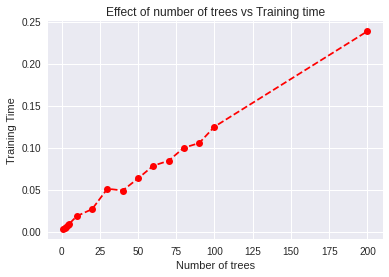

In [55]:
%matplotlib inline
plt.plot(annoy_trees, annoy_training_time, 'or--')
plt.title('Effect of number of trees vs Training time')
plt.xlabel('Number of trees')
plt.ylabel('Training Time')
plt.grid(True)
plt.show()

### Effect of number of trees vs Test time

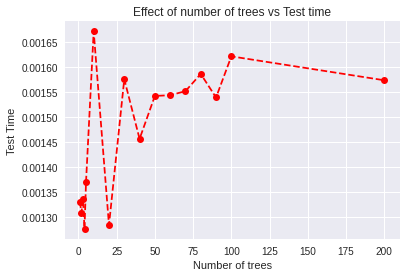

In [56]:
plt.plot(annoy_trees, annoy_test_time, 'or--')
plt.title('Effect of number of trees vs Test time')
plt.xlabel('Number of trees')
plt.ylabel('Test Time')
plt.grid(True)
plt.show()

### NMS Lib

In [57]:
!pip install nmslib
import nmslib

     |████████████████████████████████| 13.5 MB 73 kB/s 
     |████████████████████████████████| 188 kB 52.7 MB/s 


In [58]:
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(dataset)
index.createIndex({'post': 2}, print_progress=True)

In [59]:
# query for the nearest neighbors of the first datapoint
%timeit index.knnQuery(query, k=5)
ids, distances = index.knnQuery(query, k=5)

The slowest run took 21.42 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 29.2 µs per loop


In [60]:
# Get all nearest neighbors for all the datapoint
%timeit index.knnQueryBatch(dataset, k=5, num_threads=16)
neighbors = index.knnQueryBatch(dataset, k=5, num_threads=16)

10 loops, best of 5: 51.4 ms per loop


### Falconn

In [61]:
!pip install falconn
import falconn

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
  Created wheel for falconn: filename=FALCONN-1.3.1-cp37-cp37m-linux_x86_64.whl size=10582783 sha256=7d55a2af8755760483b2477ab54ead8bd7190a83672dec1aa3af25c5f19b211c
  Stored in directory: /root/.cache/pip/wheels/94/91/57/5ba08148df673f6c3cff96717120d7ad23a7493ef92040eb3e
Successfully built falconn


In [62]:
parameters = falconn.LSHConstructionParameters()
num_tables = 1
parameters.l = num_tables
parameters.dimension = num_dimensions
parameters.distance_function = falconn.DistanceFunction.EuclideanSquared
parameters.lsh_family = falconn.LSHFamily.CrossPolytope
parameters.num_rotations = 1
parameters.num_setup_threads = 1
parameters.storage_hash_table = falconn.StorageHashTable.BitPackedFlatHashTable
falconn.compute_number_of_hash_functions(16, parameters)

index = falconn.LSHIndex(parameters)
%time index.setup(dataset)

query_object = index.construct_query_object()
num_probes = 1
query_object.set_num_probes(num_probes)

%timeit query_object.find_k_nearest_neighbors(query, 5)

CPU times: user 4.49 ms, sys: 0 ns, total: 4.49 ms
Wall time: 4.9 ms
The slowest run took 39.90 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 4.41 µs per loop


In [ ]:
query = dataset[2000]
print(query_object.find_k_nearest_neighbors(query, 5))